该数据来自联邦调查局 (FBI) 的全国即时犯罪背景调查系统 (NICS)。NICS 用于确定潜在买家是否有资格购买枪支或爆炸物。

枪支店可以进入这个系统，以确保每位客户没有犯罪记录或符合资格购买。该数据已经收纳了来自 census.gov 的州级数据作为补充数据。


1.NICS 数据在一个 xlsx 文件格式的一个表格中:

它包含了按照月份 (month)、州 (state) 、类型 (type) 统计的武器调查数量 (the number of firearm checks) ;

2.美国的人口普查数据 (U.S. census data) 储存在一个 csv 文件中:

它包含了州级的几个变量，每个州的大多数变量在 2016 年只有一个数据点，但一些变量有一年以上的数据。

U.S._Census_Data.csv

gun_data.csv

##  分析目标

### 1.分析时间序列数据

>（1）美国加州的可持枪者的人均持枪数是如何随时间变化的？

>（2）近十年，加州可持枪者的人均手枪数量与人均长枪数量是怎样变化的？

>（3）最近一年，加州的手枪总数与长枪总数相比哪个更多？


### 2.分析截面数据

>（1）人均枪支数较高的州有哪些？

>（2）哪些因素可能与各州的人均持枪数有关？

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
from datetime import datetime
gd = pd.read_excel('gun_data.xlsx')

### 一、清理数据

> 1.查看并清理gun_data.xlsx数据

> 2.查看并清理U.S. Census Data.数据

#### 1.查看gun_data数据

In [2]:
gd.head(3)

,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,...,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
0,2017-09,Alabama,16717.0,0.0,5734.0,6320.0,221.0,317,0.0,15.0,...,0.0,0.0,0.0,9.0,16.0,3.0,0.0,0.0,3.0,32019
1,2017-09,Alaska,209.0,2.0,2320.0,2930.0,219.0,160,0.0,5.0,...,0.0,0.0,0.0,17.0,24.0,1.0,0.0,0.0,0.0,6303
2,2017-09,Arizona,5069.0,382.0,11063.0,7946.0,920.0,631,0.0,13.0,...,0.0,0.0,0.0,38.0,12.0,2.0,0.0,0.0,0.0,28394


In [3]:
gd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12485 entries, 0 to 12484
Data columns (total 27 columns):
month                        12485 non-null object
state                        12485 non-null object
permit                       12461 non-null float64
permit_recheck               1100 non-null float64
handgun                      12465 non-null float64
long_gun                     12466 non-null float64
other                        5500 non-null float64
multiple                     12485 non-null int64
admin                        12462 non-null float64
prepawn_handgun              10542 non-null float64
prepawn_long_gun             10540 non-null float64
prepawn_other                5115 non-null float64
redemption_handgun           10545 non-null float64
redemption_long_gun          10544 non-null float64
redemption_other             5115 non-null float64
returned_handgun             2200 non-null float64
returned_long_gun            2145 non-null float64
returned_other   

In [4]:
sum(gd.duplicated())

0

#### 数据中存在的问题：

#### 1.有大量缺失值
- 一半以上的列存在缺失值。

#### 2.类型错误
- month列的数据含有年和月，数据类型为字符型，如果转化为datetime会有助于下面的分析。

### 2. 清理gun_data.csv数据

In [5]:
# 提取年、月

gd['months'] = pd.to_datetime(gd['month'])
gd['year'] = gd['months'].dt.year
gd['mon'] = gd['months'].dt.month

In [6]:
#删掉缺失数据太多的列（除了other列）

gd.drop(['prepawn_other','redemption_other','returned_handgun','returned_long_gun','returned_other','rentals_handgun',
         'rentals_long_gun','private_sale_handgun','private_sale_long_gun','private_sale_other','return_to_seller_handgun',
         'return_to_seller_long_gun','return_to_seller_other','permit_recheck','months'], axis=1, inplace=True)
gd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12485 entries, 0 to 12484
Data columns (total 15 columns):
month                  12485 non-null object
state                  12485 non-null object
permit                 12461 non-null float64
handgun                12465 non-null float64
long_gun               12466 non-null float64
other                  5500 non-null float64
multiple               12485 non-null int64
admin                  12462 non-null float64
prepawn_handgun        10542 non-null float64
prepawn_long_gun       10540 non-null float64
redemption_handgun     10545 non-null float64
redemption_long_gun    10544 non-null float64
totals                 12485 non-null int64
year                   12485 non-null int64
mon                    12485 non-null int64
dtypes: float64(9), int64(4), object(2)
memory usage: 1.4+ MB


In [7]:
#找出剩下部分含缺失值较少的列（除了other列）

for i in gd.columns:
    if gd[i].count()!=12485:
        print(i,gd[i].count())

permit 12461
handgun 12465
long_gun 12466
other 5500
admin 12462
prepawn_handgun 10542
prepawn_long_gun 10540
redemption_handgun 10545
redemption_long_gun 10544


In [8]:
#用均值填补缺失数据

lack = ['other','permit','handgun','long_gun','admin','prepawn_handgun','prepawn_long_gun','redemption_handgun','redemption_long_gun']

for i in lack:
    gd[i].fillna(gd[i].mean(),inplace=True)

In [9]:
# 再查看各列数据是否完整

gd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12485 entries, 0 to 12484
Data columns (total 15 columns):
month                  12485 non-null object
state                  12485 non-null object
permit                 12485 non-null float64
handgun                12485 non-null float64
long_gun               12485 non-null float64
other                  12485 non-null float64
multiple               12485 non-null int64
admin                  12485 non-null float64
prepawn_handgun        12485 non-null float64
prepawn_long_gun       12485 non-null float64
redemption_handgun     12485 non-null float64
redemption_long_gun    12485 non-null float64
totals                 12485 non-null int64
year                   12485 non-null int64
mon                    12485 non-null int64
dtypes: float64(9), int64(4), object(2)
memory usage: 1.4+ MB


#### 3.查看U.S. Census Data数据

In [10]:
uc = pd.read_csv('U.S._Census_Data.csv')
uc.head(2)

,Fact,Fact Note,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,"Population estimates, July 1, 2016, (V2016)",NaN,"4,863,300","741,894","6,931,071","2,988,248","39,250,017","5,540,545","3,576,452","952,065",...,865454,6651194,"27,862,596","3,051,217","624,594","8,411,808","7,288,000","1,831,102","5,778,708","585,501"
1,"Population estimates base, April 1, 2010, (V2...",NaN,"4,780,131","710,249","6,392,301","2,916,025","37,254,522","5,029,324","3,574,114","897,936",...,814195,6346298,"25,146,100","2,763,888","625,741","8,001,041","6,724,545","1,853,011","5,687,289","563,767"


In [11]:
#删掉含有大量空值的Fact Note列

uc.drop(['Fact Note'],axis=1,inplace=True)

In [12]:
#查看持枪数据，对比两个文件，发现state序列可以作为两表之间的连接

gd.head(2)

,month,state,permit,handgun,long_gun,other,multiple,admin,prepawn_handgun,prepawn_long_gun,redemption_handgun,redemption_long_gun,totals,year,mon
0,2017-09,Alabama,16717.0,5734.0,6320.0,221.0,317,0.0,15.0,21.0,1378.0,1262.0,32019,2017,9
1,2017-09,Alaska,209.0,2320.0,2930.0,219.0,160,0.0,5.0,2.0,200.0,154.0,6303,2017,9


In [13]:
# 为了与gun_data建立连接，保持数据横纵一致，对人口统计数据进行转置

duc = uc.T
duc.head(2)

,0,1,2,3,4,5,6,7,8,9,...,75,76,77,78,79,80,81,82,83,84
Fact,"Population estimates, July 1, 2016, (V2016)","Population estimates base, April 1, 2010, (V2...","Population, percent change - April 1, 2010 (es...","Population, Census, April 1, 2010","Persons under 5 years, percent, July 1, 2016, ...","Persons under 5 years, percent, April 1, 2010","Persons under 18 years, percent, July 1, 2016,...","Persons under 18 years, percent, April 1, 2010","Persons 65 years and over, percent, July 1, 2...","Persons 65 years and over, percent, April 1, 2010",...,NaN,Value Flags,-,D,F,FN,NaN,S,X,Z
Alabama,"4,863,300","4,780,131",1.70%,"4,779,736",6.00%,6.40%,22.60%,23.70%,16.10%,13.80%,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
duc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51 entries, Fact to Wyoming
Data columns (total 85 columns):
0     51 non-null object
1     51 non-null object
2     51 non-null object
3     51 non-null object
4     51 non-null object
5     51 non-null object
6     51 non-null object
7     51 non-null object
8     51 non-null object
9     51 non-null object
10    51 non-null object
11    51 non-null object
12    51 non-null object
13    51 non-null object
14    51 non-null object
15    51 non-null object
16    51 non-null object
17    51 non-null object
18    51 non-null object
19    51 non-null object
20    51 non-null object
21    51 non-null object
22    51 non-null object
23    51 non-null object
24    51 non-null object
25    51 non-null object
26    51 non-null object
27    51 non-null object
28    51 non-null object
29    51 non-null object
30    51 non-null object
31    51 non-null object
32    51 non-null object
33    51 non-null object
34    51 non-null object
35    51 non-null o

In [15]:
# 检查冗余
sum(duc.duplicated())

0

### 数据问题：
#### 1.数据缺失
- 末尾几个列存在大量空值。

In [16]:
# 按索引删除原表的空列
uc.drop([65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84],inplace=True)

In [17]:
# 再转置后已经不存在空列
duc = uc.T
duc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51 entries, Fact to Wyoming
Data columns (total 65 columns):
0     51 non-null object
1     51 non-null object
2     51 non-null object
3     51 non-null object
4     51 non-null object
5     51 non-null object
6     51 non-null object
7     51 non-null object
8     51 non-null object
9     51 non-null object
10    51 non-null object
11    51 non-null object
12    51 non-null object
13    51 non-null object
14    51 non-null object
15    51 non-null object
16    51 non-null object
17    51 non-null object
18    51 non-null object
19    51 non-null object
20    51 non-null object
21    51 non-null object
22    51 non-null object
23    51 non-null object
24    51 non-null object
25    51 non-null object
26    51 non-null object
27    51 non-null object
28    51 non-null object
29    51 non-null object
30    51 non-null object
31    51 non-null object
32    51 non-null object
33    51 non-null object
34    51 non-null object
35    51 non-null o

### 转置后的数据存在以下问题


#### 1. column（列名称）错误
- 第二列才是想要的列名称

#### 2. 数据类型
- 人口统计的数据都是字符型，不便于后面可能的计算，需要将部分数据转换成数值型。

In [18]:
#将第二列设为列名称
duc.columns = duc.iloc[0]
duc.head()

Fact,"Population estimates, July 1, 2016, (V2016)","Population estimates base, April 1, 2010, (V2016)","Population, percent change - April 1, 2010 (estimates base) to July 1, 2016, (V2016)","Population, Census, April 1, 2010","Persons under 5 years, percent, July 1, 2016, (V2016)","Persons under 5 years, percent, April 1, 2010","Persons under 18 years, percent, July 1, 2016, (V2016)","Persons under 18 years, percent, April 1, 2010","Persons 65 years and over, percent, July 1, 2016, (V2016)","Persons 65 years and over, percent, April 1, 2010",...,"All firms, 2012","Men-owned firms, 2012","Women-owned firms, 2012","Minority-owned firms, 2012","Nonminority-owned firms, 2012","Veteran-owned firms, 2012","Nonveteran-owned firms, 2012","Population per square mile, 2010","Land area in square miles, 2010",FIPS Code
Fact,"Population estimates, July 1, 2016, (V2016)","Population estimates base, April 1, 2010, (V2...","Population, percent change - April 1, 2010 (es...","Population, Census, April 1, 2010","Persons under 5 years, percent, July 1, 2016, ...","Persons under 5 years, percent, April 1, 2010","Persons under 18 years, percent, July 1, 2016,...","Persons under 18 years, percent, April 1, 2010","Persons 65 years and over, percent, July 1, 2...","Persons 65 years and over, percent, April 1, 2010",...,"All firms, 2012","Men-owned firms, 2012","Women-owned firms, 2012","Minority-owned firms, 2012","Nonminority-owned firms, 2012","Veteran-owned firms, 2012","Nonveteran-owned firms, 2012","Population per square mile, 2010","Land area in square miles, 2010",FIPS Code
Alabama,"4,863,300","4,780,131",1.70%,"4,779,736",6.00%,6.40%,22.60%,23.70%,16.10%,13.80%,...,"374,153","203,604","137,630","92,219","272,651","41,943","316,984",94.4,"50,645.33","""01"""
Alaska,"741,894","710,249",4.50%,"710,231",7.30%,7.60%,25.20%,26.40%,10.40%,7.70%,...,"68,032","35,402","22,141","13,688","51,147","7,953","56,091",1.2,"570,640.95","""02"""
Arizona,"6,931,071","6,392,301",8.40%,"6,392,017",6.30%,7.10%,23.50%,25.50%,16.90%,13.80%,...,"499,926","245,243","182,425","135,313","344,981","46,780","427,582",56.3,"113,594.08","""04"""
Arkansas,"2,988,248","2,916,025",2.50%,"2,915,918",6.40%,6.80%,23.60%,24.40%,16.30%,14.40%,...,"231,959","123,158","75,962","35,982","189,029","25,915","192,988",56,"52,035.48","""05"""


In [19]:
# 删去重复数据（第一列）
duc.drop(duc.index[0],inplace=True)
duc.head(2)

Fact,"Population estimates, July 1, 2016, (V2016)","Population estimates base, April 1, 2010, (V2016)","Population, percent change - April 1, 2010 (estimates base) to July 1, 2016, (V2016)","Population, Census, April 1, 2010","Persons under 5 years, percent, July 1, 2016, (V2016)","Persons under 5 years, percent, April 1, 2010","Persons under 18 years, percent, July 1, 2016, (V2016)","Persons under 18 years, percent, April 1, 2010","Persons 65 years and over, percent, July 1, 2016, (V2016)","Persons 65 years and over, percent, April 1, 2010",...,"All firms, 2012","Men-owned firms, 2012","Women-owned firms, 2012","Minority-owned firms, 2012","Nonminority-owned firms, 2012","Veteran-owned firms, 2012","Nonveteran-owned firms, 2012","Population per square mile, 2010","Land area in square miles, 2010",FIPS Code
Alabama,"4,863,300","4,780,131",1.70%,"4,779,736",6.00%,6.40%,22.60%,23.70%,16.10%,13.80%,...,"374,153","203,604","137,630","92,219","272,651","41,943","316,984",94.4,"50,645.33","""01"""
Alaska,"741,894","710,249",4.50%,"710,231",7.30%,7.60%,25.20%,26.40%,10.40%,7.70%,...,"68,032","35,402","22,141","13,688","51,147","7,953","56,091",1.2,"570,640.95","""02"""


In [20]:
# 查看有多少数据的类型需要转换，以便计算后面的问题
duc.iloc[1]

Fact
Population estimates, July 1, 2016,  (V2016)                                                741,894
Population estimates base, April 1, 2010,  (V2016)                                          710,249
Population, percent change - April 1, 2010 (estimates base) to July 1, 2016,  (V2016)         4.50%
Population, Census, April 1, 2010                                                           710,231
Persons under 5 years, percent, July 1, 2016,  (V2016)                                        7.30%
Persons under 5 years, percent, April 1, 2010                                                 7.60%
Persons under 18 years, percent, July 1, 2016,  (V2016)                                      25.20%
Persons under 18 years, percent, April 1, 2010                                               26.40%
Persons 65 years and over, percent,  July 1, 2016,  (V2016)                                  10.40%
Persons 65 years and over, percent, April 1, 2010                                             7

#### 根据之前探索数据的目标，需要计算：各州的人均收入和种族比例。
#### 因此要将人口数量、人均收入、种族比例等数据转换为数值型。

#### （1）转换只含逗号的数据

In [21]:
# 重新设一列用于计算，以保留原数据。
duc['census15'] = duc['Population estimates, July 1, 2016,  (V2016)']
def trans0(data):
    list_p=[]
    count=0
    for i in data:
        a = i.split(',')
        b = ''.join(a)
        list_p.append(b)
    count+=1
    return list_p

duc['census15'] = trans0(duc['census15'])
duc['census15'] = duc['census15'].astype(int)
duc['census15']

Alabama            4863300
Alaska              741894
Arizona            6931071
Arkansas           2988248
California        39250017
Colorado           5540545
Connecticut        3576452
Delaware            952065
Florida           20612439
Georgia           10310371
Hawaii             1428557
Idaho              1683140
Illinois          12801539
Indiana            6633053
Iowa               3134693
Kansas             2907289
Kentucky           4436974
Louisiana          4681666
Maine              1331479
Maryland           6016447
Massachusetts      6811779
Michigan           9928300
Minnesota          5519952
Mississippi        2988726
Missouri           6093000
Montana            1042520
Nebraska           1907116
Nevada             2940058
New Hampshire      1334795
New Jersey         8944469
New Mexico         2081015
New York          19745289
North Carolina    10146788
North Dakota        757952
Ohio              11614373
Oklahoma           3923561
Oregon             4093465
P

In [22]:
duc['employ'] = duc['Total employment, 2015']
duc['employ'] = trans0(duc['employ'])
duc['employ'] = duc['employ'].astype(int)

In [23]:
duc['veteran'] = duc['Veterans, 2011-2015']
duc['veteran'] = trans0(duc['veteran'])
duc['veteran'] =duc['veteran'].astype(int)

#### （2）转换居民收入数

In [24]:
duc['per_income'] = duc['Per capita income in past 12 months (in 2015 dollars), 2011-2015']
duc['per_income']

Alabama           $24,091 
Alaska            $33,413 
Arizona           $25,848 
Arkansas          $22,798 
California        $30,318 
Colorado          $32,217 
Connecticut       $38,803 
Delaware          $30,554 
Florida           $26,829 
Georgia           $25,737 
Hawaii            $29,822 
Idaho             $23,399 
Illinois          $30,494 
Indiana           $25,346 
Iowa              $27,950 
Kansas            $27,706 
Kentucky          $24,063 
Louisiana         $24,981 
Maine             $27,655 
Maryland          $36,897 
Massachusetts     $36,895 
Michigan          $26,607 
Minnesota         $32,157 
Mississippi       $21,057 
Missouri          $26,259 
Montana           $26,381 
Nebraska          $27,882 
Nevada            $26,541 
New Hampshire     $34,362 
New Jersey        $36,582 
New Mexico           24012
New York             33236
North Carolina       25920
North Dakota         32035
Ohio                 26953
Oklahoma             25032
Oregon               27684
P

#### 人均收入数据中的问题
- 发现有些数据含有美元符号和逗号，有些不含有
- 需要统一为只含数字的数据

In [25]:
# 去掉符号，只留下数字
list_pi=[]
count=0
for i in duc['per_income']:
    a = i.split('$')
    for j in a:
        b = j.split(',')
        c = ''.join(b)
    list_pi.append(c)
count+=1

duc['per_income'] = list_pi
duc['per_income'] = duc['per_income'].astype(int)
duc['per_income']

Alabama           24091
Alaska            33413
Arizona           25848
Arkansas          22798
California        30318
Colorado          32217
Connecticut       38803
Delaware          30554
Florida           26829
Georgia           25737
Hawaii            29822
Idaho             23399
Illinois          30494
Indiana           25346
Iowa              27950
Kansas            27706
Kentucky          24063
Louisiana         24981
Maine             27655
Maryland          36897
Massachusetts     36895
Michigan          26607
Minnesota         32157
Mississippi       21057
Missouri          26259
Montana           26381
Nebraska          27882
Nevada            26541
New Hampshire     34362
New Jersey        36582
New Mexico        24012
New York          33236
North Carolina    25920
North Dakota      32035
Ohio              26953
Oklahoma          25032
Oregon            27684
Pennsylvania      29291
Rhode Island      31118
South Carolina    24604
South Dakota      26747
Tennessee       

#### （3）转换种族百分比
- 以2016年1月1日的白种人比例数据作为2015年的数据

In [26]:
duc['white%']=duc['White alone, percent, July 1, 2016,  (V2016)']
duc['white%']

Alabama           69.30%
Alaska            66.10%
Arizona           83.30%
Arkansas          79.40%
California        72.70%
Colorado          87.50%
Connecticut       80.60%
Delaware          70.10%
Florida           77.60%
Georgia           61.20%
Hawaii            25.80%
Idaho             93.30%
Illinois          77.20%
Indiana           85.60%
Iowa              91.40%
Kansas            86.60%
Kentucky          88.00%
Louisiana         63.20%
Maine             94.80%
Maryland          59.30%
Massachusetts     81.80%
Michigan          79.60%
Minnesota         85.00%
Mississippi       59.30%
Missouri          83.20%
Montana           89.20%
Nebraska          88.90%
Nevada            75.10%
New Hampshire     93.80%
New Jersey        72.40%
New Mexico         0.826
New York           0.699
North Carolina      0.71
North Dakota       0.879
Ohio               0.825
Oklahoma           0.746
Oregon             0.874
Pennsylvania       0.824
Rhode Island       0.844
South Carolina     0.685


#### 人种比例数据中的问题
- 发现有些数据以%为单位表示，且含有%符号，有些以小数位表示
- 需要统一为只含数字的数据，小数位统一为以%表示的两位数

In [27]:
# 定义转换函数
def trans1(data):
    list_i=[]
    count=0
    for i in data:
        a=i.split('%')
        b = a[0].split('.')
        c =''.join(b)
        list_i.append(c)
    count+=1
    return list_i

def trans2(file):
    file = file.astype(int)
    file = file.apply(lambda x:x/100 if x>1000 else x/10)
    return file

In [28]:
duc['degree%'] = duc["Bachelor's degree or higher, percent of persons age 25 years+, 2011-2015"]
duc['female%'] = duc['Female persons, percent,  July 1, 2016,  (V2016)']
duc['insurance%'] = duc['Persons  without health insurance, under age 65 years, percent']
duc['black%'] = duc['Black or African American alone, percent, July 1, 2016,  (V2016)']
duc['American_Indian%'] = duc['American Indian and Alaska Native alone, percent, July 1, 2016,  (V2016)']                   
duc['Latino%'] = duc['Hispanic or Latino, percent, July 1, 2016,  (V2016)']         
duc['Asian%']=duc['Asian alone, percent, July 1, 2016,  (V2016)']
duc['Foreign%'] = duc['Foreign born persons, percent, 2011-2015']

In [29]:
# 由于遇到 AttributeError: 'list' object has no attribute 'astype'，所以这么麻烦，重复了很多步骤。
# 如果能更简单地函数解决就再好不过了，希望得到宝贵建议

duc['degree%'] = trans1(duc['degree%'])
duc['degree%'] = trans2(duc['degree%'])
duc['female%'] = trans1(duc['female%'])
duc['female%'] = trans2(duc['female%'])
duc['insurance%'] = trans1(duc['insurance%'])
duc['insurance%'] = trans2(duc['insurance%'])                        
duc['black%'] = trans1(duc['black%'])
duc['black%'] = trans2(duc['black%'])
duc['American_Indian%'] = trans1(duc['American_Indian%'])
duc['American_Indian%'] = trans2(duc['American_Indian%'])
duc['Latino%'] = trans1(duc['Latino%'])
duc['Latino%'] = trans2(duc['Latino%'])                        
duc['Asian%'] = trans1(duc['Asian%'])
duc['Asian%'] = trans2(duc['Asian%'])      
duc['Foreign%'] = trans1(duc['Foreign%'])
duc['Foreign%'] =trans2(duc['Foreign%'])

## 二、开始探索数据

### 1.分析时间序列数据

>（1）美国加州的可持枪者的人均持枪数是如何随时间变化的？

>（2）近十年，加州可持枪者的人均手枪数量与人均长枪数量是怎样变化的？

>（3）最近一年，加州的手枪总数与长枪总数相比哪个更多？

In [30]:
# （1）合法持枪人数等于持枪许可证

gd.head(2)

,month,state,permit,handgun,long_gun,other,multiple,admin,prepawn_handgun,prepawn_long_gun,redemption_handgun,redemption_long_gun,totals,year,mon
0,2017-09,Alabama,16717.0,5734.0,6320.0,221.0,317,0.0,15.0,21.0,1378.0,1262.0,32019,2017,9
1,2017-09,Alaska,209.0,2320.0,2930.0,219.0,160,0.0,5.0,2.0,200.0,154.0,6303,2017,9


In [31]:
# 计算枪支总数
gdgun = gd['handgun'] + gd['long_gun'] + gd['other']
gd['gun'] = gdgun

# 计算持证者的人均枪支数
gdper = gd['gun'] / gd['permit']
gd['pergun'] = gdper

In [32]:
gd.head(2)

,month,state,permit,handgun,long_gun,other,multiple,admin,prepawn_handgun,prepawn_long_gun,redemption_handgun,redemption_long_gun,totals,year,mon,gun,pergun
0,2017-09,Alabama,16717.0,5734.0,6320.0,221.0,317,0.0,15.0,21.0,1378.0,1262.0,32019,2017,9,12275.0,0.734282
1,2017-09,Alaska,209.0,2320.0,2930.0,219.0,160,0.0,5.0,2.0,200.0,154.0,6303,2017,9,5469.0,26.167464


In [33]:
# 只查看加州的数据
ca = gd.query('state == "California"')

ca.drop(['multiple','admin','prepawn_handgun','prepawn_long_gun','redemption_handgun',
         'redemption_long_gun','totals'],axis = 1,inplace =True)

# 先保存加州的数据，以备不患
ca.to_csv('ca_gun.csv')

D:\anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [34]:
# 查看数据

ca.head()

,month,state,permit,handgun,long_gun,other,year,mon,gun,pergun
4,2017-09,California,57839.0,37165.0,24581.0,2984.0,2017,9,64730.0,1.119141
59,2017-08,California,59528.0,41110.0,26220.0,3058.0,2017,8,70388.0,1.182435
114,2017-07,California,52610.0,37027.0,21721.0,2514.0,2017,7,61262.0,1.164455
169,2017-06,California,60142.0,42726.0,23807.0,2763.0,2017,6,69296.0,1.152206
224,2017-05,California,58722.0,42442.0,24495.0,2760.0,2017,5,69697.0,1.186898


In [35]:
ca['year'].value_counts()

2007    12
1999    12
2001    12
2002    12
2003    12
2004    12
2005    12
2006    12
2016    12
2008    12
2009    12
2010    12
2011    12
2012    12
2013    12
2014    12
2015    12
2000    12
2017     9
1998     2
Name: year, dtype: int64

#### 加州持枪数据存在的问题
- 数据的时间跨度是1998年到2017年，除了开头和结尾的年份，其余都是十二个月的数据
- 然而，以月为单位的数据不便于查看和作图，需要对每年计算一个均值。

#### （1）加州可持枪者的人均持枪数变化趋势

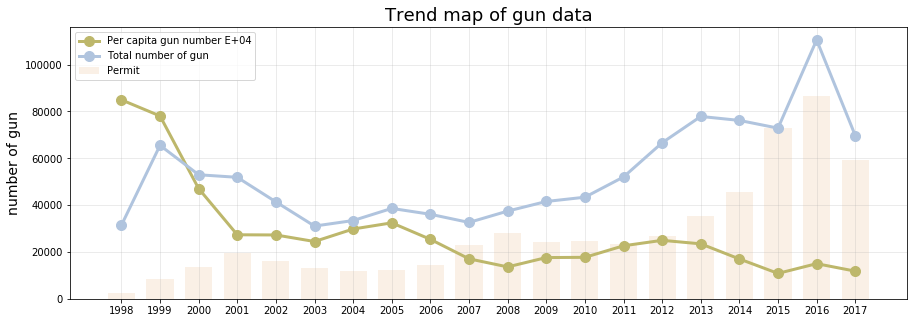

In [36]:
# 整理作图的变量

col = ['1998','1999','2000','2001','2002','2003','2004',
       '2005','2006','2007','2008','2009','2010','2011',
       '2012','2013','2014','2015','2016','2017']

pergun=[]
allgun=[]
permit=[]

i = 0
for j in col:
    ca_year = ca[ca['year'] == int(j)]
    # 为了更好地显示人均持枪数据的变化，对每个值乘10^4
    a = ca_year['pergun'].mean()*10000
    b = ca_year['gun'].mean()
    c = ca_year['permit'].mean()
    pergun.append(a)
    allgun.append(b)
    permit.append(c)
i+=1

pergun = dict(zip(col,pergun))
allgun = dict(zip(col,allgun))
permit = dict(zip(col,permit))

# 对以年为单位的人均持枪数据作趋势图

plt.figure(figsize=(15,5))
pergun = plt.plot(pergun.keys(),pergun.values(),color='darkkhaki', linewidth=3, alpha=1,
                 marker='o',markerfacecolor='darkkhaki',markersize=10)
allgun = plt.plot(allgun.keys(),allgun.values(),color='lightsteelblue', linewidth=3,
                  alpha=1,marker='o',markerfacecolor='lightsteelblue',markersize=10)
permit = plt.bar(permit.keys(),permit.values(),color='linen', width=.7,alpha=1)

plt.ylabel('number of gun',fontsize = 14)
plt.title('Trend map of gun data',fontsize = 18)

plt.legend(labels = ['Per capita gun number E+04','Total number of gun' ,'Permit'], loc = 'best')
plt.grid(alpha= 0.3)

#### （2）近十年，加州可持枪者的人均手枪数与人均长枪数的变化

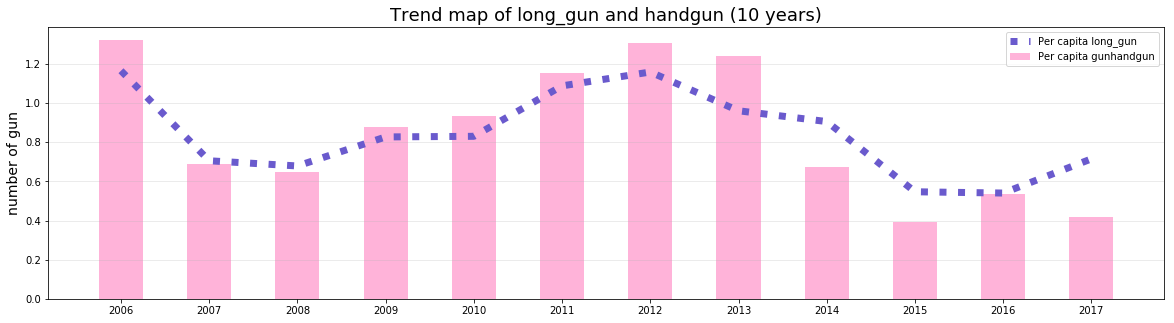

In [37]:
col = ['2006','2007','2008','2009','2010','2011',
       '2012','2013','2014','2015','2016','2017']
longgun=[]
handgun=[]
i = 0
for j in col:
    ca_year = ca[ca['year'] == int(j)]
    a = ca_year['long_gun'].mean()/ca_year['permit'].mean()
    b = ca_year['handgun'].mean()/ca_year['permit'].mean()
    longgun.append(a)
    handgun.append(b)
i+=1
longgun = dict(zip(col,longgun))
handgun = dict(zip(col,handgun))

plt.figure(figsize=(20,5))
longgun = plt.bar(longgun.keys(),longgun.values(),color='hotpink', width=.5, alpha=.5)
handgun = plt.plot(handgun.keys(),handgun.values(),color='slateblue', linewidth=7,ls=':',alpha=1)
plt.ylabel('number of gun',fontsize = 14)
plt.title('Trend map of long_gun and handgun (10 years)',fontsize = 18)

plt.legend(labels = ['Per capita long_gun', 'Per capita gunhandgun'], loc = 'best')
plt.grid(axis='y',alpha= 0.3)

#### （3）2016年以来加州手枪与长枪总数的变化

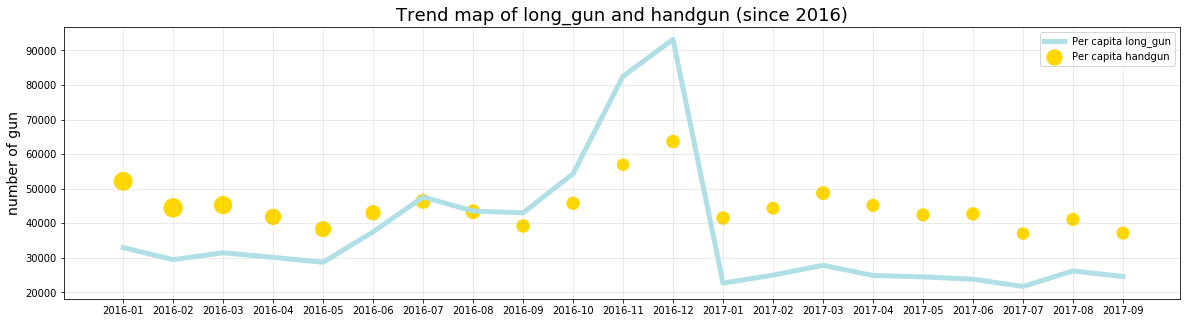

In [38]:
ca_year = ca[ca['year'] > 2015]
time = ca_year['month']

longgun = dict(zip(time,ca_year['long_gun']))
handgun = dict(zip(time,ca_year['handgun']))
permit = ca_year['permit']/400

plt.figure(figsize=(20,5))
longgun = plt.plot(longgun.keys(),longgun.values(),color='powderblue', linewidth=5,alpha=1)
handgun = plt.scatter(handgun.keys(),handgun.values(),color='gold',s=permit,alpha=1)
plt.ylabel('number of gun',fontsize = 14)
plt.title('Trend map of long_gun and handgun (since 2016)',fontsize = 18)

plt.legend(labels = ['Per capita long_gun', 'Per capita handgun'], loc = 'best')
plt.grid(alpha= 0.3)

#### 通过图中曲线发现：

> 美国加州持枪总数与可持枪人数（有许可证的人数）都在逐年上升，然而可持枪者的人均持枪数逐年下降。

> 对于加州的可持枪者而言，2006~2009年人均持有的长枪和手枪数量不相上下，2009~2013年人均长枪超过人均手枪数量，2013~2017年相反。

> 自2016年以来，加州可持枪人数（圆点的大小）逐渐减少，2017年1月之后，手枪数量一直在长枪数量之上。

### 2.分析截面数据

>（1）人均枪支数较高的州有哪些？

>（2）哪些因素可能与各州的人均持枪数有关？

- U.S. Census Data.csv的统计时间节点为2016年1月1日或4月1日，

- 为了联立两表，选取gun_data.csv中2015年的均值作为2016年年初的统计值。


#### （1）各州枪支总数、人口总数的分布

In [39]:
gd_15 = gd.query('year==2015')
gd_15.drop(['handgun','long_gun','other','multiple','admin','prepawn_handgun','prepawn_long_gun','redemption_handgun',
         'redemption_long_gun','totals'],axis = 1,inplace =True)
gd_uni = gd_15.query('mon==12')

D:\anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
state = gd_uni['state']
guns=[]
permits=[]
j=0
for i in state:
    gd_state = gd_15[gd_15['state'] == i]
    a = gd_state['gun'].mean()
    b = gd_state['permit'].mean()
    guns.append(a)
    permits.append(b)
j+=1

gd_uni['guns'] = guns
gd_uni['permits'] = permits
gd_uni.drop(['month','mon','year','pergun','gun','permit'],axis=1,inplace=True)
gd_uni.head()

D:\anaconda\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
D:\anaconda\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\anaconda\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,state,guns,permits
1155,Alabama,35770.916667,20516.916667
1156,Alaska,6314.666667,223.500000
1157,Arizona,20870.916667,3989.416667
1158,Arkansas,13562.916667,4626.333333
1159,California,72886.833333,72802.666667


In [41]:
col = duc.columns

for i in col[:65]:
    duc.drop(i,axis=1,inplace=True)

In [42]:
duc.rename(columns=lambda x:x.replace('Fact','state'), inplace=True)
duc['state'] = duc.index
dc = pd.merge(gd_uni,duc,on='state')
dc.head()

,state,guns,permits,census15,employ,veteran,per_income,white%,degree%,female%,insurance%,black%,American_Indian%,Latino%,Asian%,Foreign%
0,Alabama,35770.916667,20516.916667,4863300,1634391,363170,24091,69.30%,23.5,51.6,10.7,26.8,7.0,42.0,14.0,35.0
1,Alaska,6314.666667,223.500000,741894,267999,69323,33413,66.10%,28.0,47.7,15.5,38.0,15.2,70.0,63.0,74.0
2,Arizona,20870.916667,3989.416667,6931071,2295186,505794,25848,83.30%,27.5,50.3,11.9,49.0,54.0,30.9,34.0,13.5
3,Arkansas,13562.916667,4626.333333,2988248,1003113,220953,22798,79.40%,21.1,50.9,93.0,15.7,10.0,73.0,16.0,47.0
4,California,72886.833333,72802.666667,39250017,14325377,1777410,30318,72.70%,31.4,50.3,83.0,65.0,17.0,38.9,14.8,27.0


In [43]:
perguns = dc['guns']/dc['census15']
employs = dc['employ']/dc['census15']
veterans = dc['veteran']/dc['census15']

dc['perguns'] = perguns
dc['employs'] = employs
dc['veterans'] = veterans

dc.sort_values(by="perguns" , ascending=False,inplace=True)
dc.head()

,state,guns,permits,census15,employ,veteran,per_income,white%,degree%,female%,insurance%,black%,American_Indian%,Latino%,Asian%,Foreign%,perguns,employs,veterans
1,Alaska,6314.666667,223.500000,741894,267999,69323,33413,66.10%,28.0,47.7,15.5,38.0,15.2,70.0,63.0,74.0,0.008512,0.361236,0.093441
40,South Dakota,7071.250000,744.000000,865454,353540,63742,26747,0.852,2.7,49.6,10.3,0.2,0.9,3.7,1.5,0.3,0.008171,0.408502,0.073652
47,West Virginia,14787.583333,2627.833333,1831102,565435,150021,23450,93.60%,19.2,50.5,65.0,36.0,2.0,15.0,8.0,15.0,0.008076,0.308795,0.081929
25,Montana,7906.833333,1069.250000,1042520,375041,90000,26381,89.20%,29.5,49.7,98.0,6.0,66.0,36.0,8.0,21.0,0.007584,0.359745,0.086329
0,Alabama,35770.916667,20516.916667,4863300,1634391,363170,24091,69.30%,23.5,51.6,10.7,26.8,7.0,42.0,14.0,35.0,0.007355,0.336066,0.074676


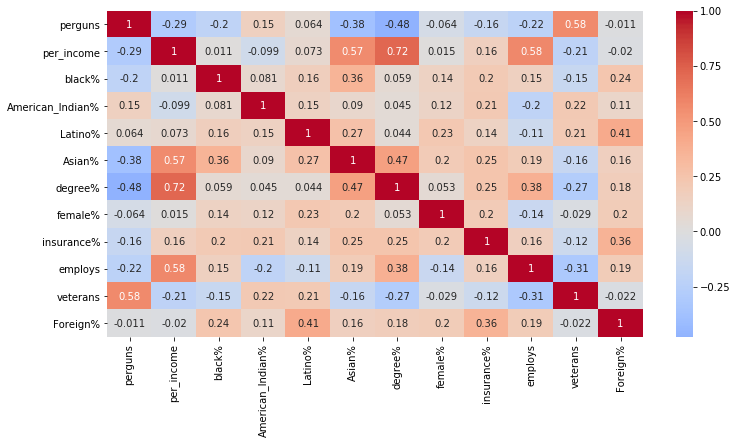

In [44]:
plt.figure(figsize=(12,6))
data = dc[['perguns','per_income','white%','black%','American_Indian%','Latino%','Asian%',
           'degree%','female%','insurance%','employs','veterans','Foreign%']].corr()
sns.heatmap(data,annot=True,center=0,cmap='coolwarm')

> 相关系数

> 0.8-1.0 极强相关，0.6-0.8 强相关，0.4-0.6 中等程度相关，0.2-0.4 弱相关，0.0-0.2 极弱相关或无相关


#### 通过热力图发现:

- 退伍军人veterans的占比（0.58）和大学及以上学历degree的比例（-0.48）与各州的人均持枪数量中度相关；


- 亚裔 Asian占比（-0.38）、人均收入per_income（-0.29）、就业率employs（-0.22）与各州的人均持枪数弱相关。


## 总结:

1. 1998年到2017年，美国加州可持枪者的人均持枪数逐年下降。


2. 近几年来，加州的可持枪者的人均手枪数量逐渐超过了人均长枪数量。


3. 从美国各州来看，退伍军人多的地方，人均持枪数更多；高学历者越多的地方，人均持枪数量越少。


4. 人均持枪数量越少的州，可能存在亚裔较多、人均收入较高、就业率较高等特点。

#### 存在的局限性：

 - 清理数据的方法还有待提升
 
 - 相关分析的数据总量，变量的种类都不够多，截面数据的统计无法保证在完全精确的同一时间。